# Google Colab Set Up

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install datasets

# Imports

In [46]:
# standard imports
import json
import re

# installed imports
import numpy as np
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    accuracy_score,
    precision_recall_fscore_support,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    RobertaTokenizer,  # tokenizer for DistilRoBERTa
    RobertaForSequenceClassification,  # base RoBERTa model
    Trainer,
    TrainingArguments,
)
from transformers.modeling_outputs import SequenceClassifierOutput



In [5]:
print("GPU available:", torch.cuda.is_available())

GPU available: True


# Global Constants

In [6]:
# paths to the datasets
train_file_path = "/content/drive/MyDrive/Colab Notebooks/COLING_2025_MGT_Workshop_Task1/en_train.jsonl"
val_file_path = "/content/drive/MyDrive/Colab Notebooks/COLING_2025_MGT_Workshop_Task1/en_dev.jsonl"
test_file_path = "/content/drive/MyDrive/Colab Notebooks/COLING_2025_MGT_Workshop_Task1/test_set_en_with_label.jsonl"

# constants
RANDOM_SEED = 42

# 1. Data Preparation


## 1.1. Load JSONL Files

In [7]:
def load_jsonl(file_path):
    """
    Load a JSONL file and return a pandas DataFrame.

    Args:
        file_path (str): The path to the JSONL file.

    Returns:
        pd.DataFrame: DataFrame containing the JSONL file's data.
    """
    with open(file_path, 'r') as file:
        data = [json.loads(line) for line in file]  # read each line and parse as JSON
    return pd.DataFrame(data)  # convert to DataFrame


## 1.2. Load Datasets

In [8]:
full_train_df = load_jsonl(train_file_path)
full_val_df = load_jsonl(val_file_path)
full_test_df = load_jsonl(test_file_path)

In [54]:
# only keep relevant columns
train_df = full_train_df[["text", "label"]]
val_df = full_val_df[["text", "label"]]
test_df = full_test_df[["text", "label"]]

In [55]:
# rename "label" column to "labels"
train_df.rename(columns={"label": "labels"}, inplace=True)
val_df.rename(columns={"label": "labels"}, inplace=True)
test_df.rename(columns={"label": "labels"}, inplace=True)

<ipython-input-55-e6c2d34d4884>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.rename(columns={"label": "labels"}, inplace=True)
<ipython-input-55-e6c2d34d4884>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.rename(columns={"label": "labels"}, inplace=True)
<ipython-input-55-e6c2d34d4884>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.rename(columns={"label": "labels"}, inplace=True)


In [56]:
print(f"training set size: {len(train_df)}")
print(f"validation set size: {len(val_df)}")
print(f"test set size: {len(test_df)}")

training set size: 610767
validation set size: 261758
test set size: 73941


In [12]:
len(train_df) * 0.5

305383.5

In [13]:
len(val_df) * 0.2

52351.600000000006

In [14]:
300/(350)

0.8571428571428571

## 1.3. Reduce Datasets

In [57]:
# define proportions
training_fraction = 0.5  # use 50% of the current training set
validation_fraction = 0.20  # use 20% of the current validation set
#test_fraction = 1  # use % of the current test set


# reduce training set
train_df, _ = train_test_split(
    train_df,
    test_size=1 - training_fraction,
    stratify=train_df["labels"],  # maintain label distribution
    random_state=RANDOM_SEED,
)

# reduce validation set
val_df, _ = train_test_split(
    val_df,
    test_size=1 - validation_fraction,
    stratify=val_df["labels"],  # maintain label distribution
    random_state=RANDOM_SEED,
)

# reduce test set
#test_df, _ = train_test_split(
#    test_df,
#    test_size=1 - test_fraction,
#    stratify=test_df["labels"],  # maintain label distribution
#    random_state=RANDOM_SEED,
#)


In [58]:
# display the new sizes
print(f"reduced training set: {len(train_df)}")
print(f"reduced validation set: {len(val_df)}")
print(f"reduced test set: {len(test_df)}")

reduced training set: 305383
reduced validation set: 52351
reduced test set: 73941


## 1.4. Convert DataFrames to HuggingFace Datasets

In [59]:
# convert datasets to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [18]:
train_dataset

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 305383
})

# 2. Tokenization

In [60]:
def tokenize_function(examples):
    """
    Tokenize text data using a pre-trained DistilRoBERTa tokenizer.

    Args:
        examples (dict): Dictionary containing text data.

    Returns:
        dict: Tokenized inputs with truncation and padding.
    """
    from transformers import AutoTokenizer  # import inside the function for worker processes
    tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")  # initialize tokenizer in each process
    return tokenizer(
        examples["text"],
        truncation=True,  # truncate sequences longer than 512 tokens
        padding="max_length",  # pad shorter sequences to 512 tokens
        max_length=512,  # set maximum token length
    )

In [61]:
# tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True, batch_size=500, num_proc=8)
val_dataset = val_dataset.map(tokenize_function, batched=True, batch_size=500, num_proc=8)
test_dataset = test_dataset.map(tokenize_function, batched=True, batch_size=500, num_proc=8)


Map (num_proc=8):   0%|          | 0/305383 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/52351 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/73941 [00:00<?, ? examples/s]

In [62]:
# set format for PyTorch (required by Trainer)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [63]:
print(train_dataset.column_names)  # should include ['input_ids', 'attention_mask', 'labels']
print(val_dataset.column_names)  # should include ['input_ids', 'attention_mask', 'labels']
print(test_dataset.column_names)  # should include ['input_ids', 'attention_mask', 'labels']

['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask']
['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask']
['text', 'labels', 'input_ids', 'attention_mask']


In [64]:
# remove unnecessary columns
train_dataset = train_dataset.remove_columns(["__index_level_0__", "text"])
val_dataset = val_dataset.remove_columns(["__index_level_0__", "text"])
test_dataset = test_dataset.remove_columns(["text"])

In [65]:
print(train_dataset.column_names)
print(val_dataset.column_names)
print(test_dataset.column_names)

['labels', 'input_ids', 'attention_mask']
['labels', 'input_ids', 'attention_mask']
['labels', 'input_ids', 'attention_mask']


# 3. Compute Class Weights

In [30]:
# compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),  # convert classes to a NumPy array
    y=train_df["labels"].values  # labels from your training data
)

# convert to a PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")

Class Weights: tensor([1.3340, 0.7998])


# 4. Custom DistilRoBERTa Model with Weighted Loss

In [31]:
class CustomDistilRobertaForSequenceClassification(nn.Module):
    """
    Custom DistilRoBERTa model for sequence classification with weighted loss.
    """

    def __init__(self, pretrained_model_name_or_path=None, num_labels=None, class_weights=None, config=None):
        """
        Initializes the custom model for sequence classification with weighted loss.

        Args:
            pretrained_model_name_or_path (str): Path or name of the pretrained model.
            num_labels (int): Number of labels for classification.
            class_weights (torch.Tensor): Class weights for handling imbalanced datasets.
            config (transformers.PretrainedConfig): Configuration object.
        """
        super().__init__()

        if config is None:
            # create a config if none is provided
            config = AutoConfig.from_pretrained(pretrained_model_name_or_path, num_labels=num_labels)

        self.class_weights = class_weights  # store class weights

        # load the base model
        self.model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path, config=config)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # forward pass through the base model
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits  # Extract logits

        loss = None
        if labels is not None:
            # use weighted cross-entropy loss
            loss_fn = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fn(logits, labels)

        # return the output as a SequenceClassifierOutput object
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [32]:
# instantiate the custom model
model = CustomDistilRobertaForSequenceClassification(
    pretrained_model_name_or_path="distilroberta-base",
    num_labels=2,
    class_weights=class_weights
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# clear GPU cache
torch.cuda.empty_cache()

# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomDistilRobertaForSequenceClassification(
  (model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-5): 6 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelf

In [34]:
print(next(model.parameters()).device)

cuda:0


# 5. Training

## 5.1. Training Set Up

In [35]:
def compute_metrics(eval_pred):
    """
    Compute evaluation metrics: accuracy, precision, recall, F1 score, and eval_loss placeholder.

    Args:
        eval_pred (tuple): A tuple containing the predictions and true labels:
            - logits (np.ndarray): Model predictions.
            - labels (np.ndarray): True labels.

    Returns:
        dict: Dictionary containing accuracy, precision, recall, F1 score, and eval_loss.
    """
    # debugging: print intermediate values
    #print(f"inside of compute_metrics() function!!")

    logits, labels = eval_pred  # unpack predictions and labels
    predictions = logits.argmax(axis=-1)  # convert logits to predicted classes

    # calculate precision, recall, and f1 using sklearn
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    accuracy = accuracy_score(labels, predictions)  # calculate accuracy

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


In [41]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/comp6781-project/results",  # directory to save results
    eval_strategy="epoch",  # evaluate at the end of each epoch
    save_strategy="epoch",  # save checkpoints at the end of each epoch
    save_total_limit=2,  # keep only the last 2 checkpoints
    learning_rate=2e-5,  # initial learning rate
    per_device_train_batch_size=32,  # batch size for training
    #gradient_accumulation_steps=1,  # no gradient accumulation
    per_device_eval_batch_size=32,  # batch size for evaluation
    num_train_epochs=3,  # number of training epochs
    weight_decay=0.01,  # apply weight decay
    #fp16=True,  # enable mixed precision
    metric_for_best_model="accuracy",  # use accuracy as the metric to select the best model
    greater_is_better=True,  # higher accuracy is better
    remove_unused_columns=False,  # do not remove columns from the dataset
    logging_dir="/content/drive/MyDrive/Colab Notebooks/comp6781-project/logs",  # log directory
    logging_steps=5000,  # logging frequency every 50 steps
    load_best_model_at_end=True,  # load the best model at the end
    report_to="none",
)


In [42]:
trainer = Trainer(
    model=model,  # use the custom model
    args=training_args,  # training arguments
    train_dataset=train_dataset,  # training dataset
    eval_dataset=val_dataset,  # validation dataset
    compute_metrics=compute_metrics,  # evaluation metrics
)


In [43]:
from accelerate import Accelerator

# re-initialize the Accelerator
accelerator = Accelerator()
trainer.accelerator = accelerator

# evaluate the model
#metrics = trainer.evaluate()
#print(metrics)

## 5.2. Start Training

In [44]:
# train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.165600,0.194885,0.944375,0.932661,0.981796,0.956598
2,0.079400,0.337630,0.940211,0.921674,0.988221,0.953788
3,0.048100,0.486342,0.935780,0.911923,0.993055,0.950762


TrainOutput(global_step=28632, training_loss=0.08764878449142895, metrics={'train_runtime': 9117.4596, 'train_samples_per_second': 100.483, 'train_steps_per_second': 3.14, 'total_flos': 0.0, 'train_loss': 0.08764878449142895, 'epoch': 3.0})

# 6. Evaluation

## 6.1. Overall Results

In [45]:
# evaluate on the training set
train_metrics = trainer.evaluate(train_dataset)

print("Training Results:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")


Training Results:
eval_loss: 0.1546497642993927
eval_accuracy: 0.9536581931541703
eval_precision: 0.9414570555211476
eval_recall: 0.9872670514660438
eval_f1: 0.963818026558673
eval_runtime: 928.2764
eval_samples_per_second: 328.979
eval_steps_per_second: 10.281
epoch: 3.0


In [47]:
# evaluate on the validation set
val_metrics = trainer.evaluate(val_dataset)

print("Validation Results:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value}")

Validation Results:
eval_loss: 0.19488483667373657
eval_accuracy: 0.9443754656071517
eval_precision: 0.9326610090676587
eval_recall: 0.9817964877929388
eval_f1: 0.9565982055027276
eval_runtime: 161.0973
eval_samples_per_second: 324.965
eval_steps_per_second: 10.155
epoch: 3.0


In [48]:
# evaluate on the test set
test_metrics = trainer.evaluate(test_dataset)

print("Test Results:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value}")

Test Results:
eval_loss: 1.3903391361236572
eval_accuracy: 0.7388593608417522
eval_precision: 0.6821924811480947
eval_recall: 0.9515356797229155
eval_f1: 0.7946615621842931
eval_runtime: 227.3829
eval_samples_per_second: 325.183
eval_steps_per_second: 10.163
epoch: 3.0


## 6.2. Confusion Matrix

In [49]:
def generate_predictions_and_labels(trainer, dataset):
    """
    Generate predictions and true labels for a given dataset.

    Args:
        trainer (transformers.Trainer): The HuggingFace Trainer instance.
        dataset (datasets.Dataset): The dataset to evaluate.

    Returns:
        tuple: A tuple containing predicted labels (numpy.ndarray) and true labels (numpy.ndarray).
    """
    predictions = trainer.predict(dataset)  # get predictions
    logits = predictions.predictions        # extract logits
    true_labels = dataset["labels"]         # ground truth labels

    # convert logits to predicted class labels
    if len(logits.shape) == 1:  # binary classification with single logit
        predicted_labels = (logits > 0).astype(int)
    else:                       # multi-class or binary with two logits
        predicted_labels = np.argmax(logits, axis=1)

    return predicted_labels, true_labels


In [50]:
def display_confusion_matrix(y_true, y_pred, title="Confusion Matrix", figsize=(3, 3)):
    """
    Compute and display the confusion matrix.

    Args:
        y_true (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.
        title (str): Title for the confusion matrix plot. Defaults to "Confusion Matrix".
        figsize (tuple): Figure size for the plot. Defaults to (6, 6).

    Returns:
        numpy.ndarray: The confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)  # compute confusion matrix
    fig, ax = plt.subplots(figsize=figsize)  # set figure size
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="viridis", ax=ax)  # plot with viridis colormap on specified axes
    disp.ax_.set_title(title)  # set title for the plot
    plt.show()  # display the plot
    return cm

Confusion Matrix for Training Set:


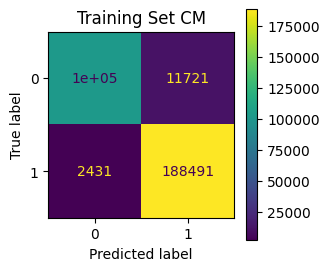

In [51]:
# training set
train_predictions, train_labels = generate_predictions_and_labels(trainer, train_dataset)
print("Confusion Matrix for Training Set:")
cm_train = display_confusion_matrix(train_labels, train_predictions, title="Training Set CM")

Confusion Matrix for Validation Set:


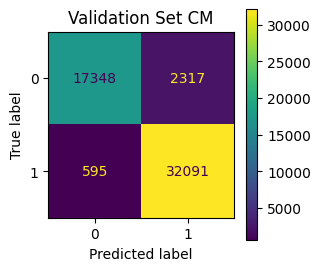

In [52]:
# validation set
val_predictions, val_labels = generate_predictions_and_labels(trainer, val_dataset)
print("Confusion Matrix for Validation Set:")
cm_val = display_confusion_matrix(val_labels, val_predictions, title="Validation Set CM")

Confusion Matrix for Test Set:


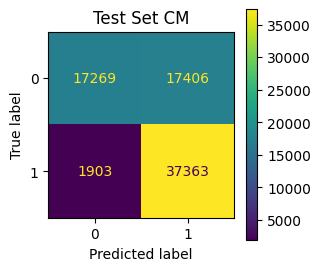

In [53]:
# test set
test_predictions, test_labels = generate_predictions_and_labels(trainer, test_dataset)
print("Confusion Matrix for Test Set:")
cm_test = display_confusion_matrix(test_labels, test_predictions, title="Test Set CM")


## 6.3. Classifying a Single Sample

In [77]:
def classify_text(model, text_sample, device, label_map=None):
    """
    Classify a single text sample as either AI-generated or Human-written.

    Args:
        model (nn.Module): The trained classification model.
        tokenizer (AutoTokenizer): Tokenizer for the model.
        text_sample (str): The text sample to classify.
        device (torch.device): Device to perform inference (CPU/GPU).
        label_map (dict, optional): A dictionary mapping labels to human-readable text.
                                    Defaults to {0: "AI-generated", 1: "Human-written"}.

    Returns:
        str: Predicted class label (e.g., "AI-generated" or "Human-written").
    """
    if label_map is None:
        label_map = {0: "AI-generated", 1: "Human-written"}

    # tokenize and move inputs to the same device as the model
    tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
    inputs = tokenizer(
        text_sample,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(device)

    # ensure model is on the correct device
    model.to(device)

    # forward pass through the model
    outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

    # extract logits and calculate predicted label
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=-1).item()

    # interpret the prediction
    return f"Predicted class: {predicted_label} ({label_map[predicted_label]})"


In [82]:
# sample to classify
text_sample_human = "This is a short sample of text written by a human to test the performance of the model."
print(classify_text(model, text_sample_human, device))

Predicted class: 1 (Human-written)


In [85]:
# classify an AI-generated sample generated with ChatGPT 4
text_sample_ai = "The latest smartphone model hits the market this week, featuring an improved battery life and a faster processor. It comes equipped with a high-resolution camera capable of capturing stunning photos even in low light conditions. The device also includes enhanced security features such as facial recognition and fingerprint scanning, making it a top choice for tech enthusiasts looking for both performance and reliability."
print(classify_text(model, text_sample_ai, device))

Predicted class: 1 (Human-written)


The classification failed... not so surprising, one 1.6% of the training set was generated with GPT4.